# Flame Workflow - MUL - 24APR20 - 10m lines - S2b

In [1]:
import time
start_time = time.time()

from datetime import datetime, timedelta
import pandas as pd
import numpy as np 
import glob, os, subprocess

import matplotlib.pyplot as plt
import matplotlib
import datacube
import sys, shutil

#
# Add to path the directory where all the Flame-specific code resides.
#
sys.path.append("..")
from SRC import *

%matplotlib inline
matplotlib.rcParams.update({'font.size': 11})
matplotlib.rcParams['savefig.dpi'] = 300

#################################
# Specify directories and files #
#################################
# indir = Directory that contains flame spectra in csv format files
# outdir = Directory where plots will be written
# calfile = Flame calibration files to convert from DN to radiance
# TelemetryFile = Telemetry/GPS data from the drone
#
indir = '../MULLION/24APR20/flame_data/10m_lines/'
outdir = '../PNGS/MULLION/24APR20_10m/'
calfile = '../CALIBRATION/RadCalCoeff_GT08_.csv'
TelemetryFile = '../MULLION/24APR20/log_files/Apr-24th-2020-10-18AM-Flight-Airdata_10m_lines.csv'

#
# field_data contains entries relevant for particular campaign. They are:
# 0: Three letter abbreviation for field site name
# 1: Date
# 2: Comment
# 3: Name of platform
# 4: Which panel was used
# 5: Whether the data were taken in radiance or reflectance mode (not used)
# 6: Whether satellite data is collection 5 or 6 (assumed to be C5)
# 7: Not used, but must be blank
#
field_data = ['MUL', '24APR20', '10mLines', 'Sentinel2b', 'GA 10inch Panel 99aa03-0319-1952', 'Radiance', '', '']

#
# Start labelling Figures at number 1
#
fignum=1

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 1

#
# Define BRDF parameters for site and date
#
brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.06538, 0.01958666666666667, 0.009953333333333333],
                          ['band11', 0.39993333333333336, 0.11646333333333335, 0.05016],
                          ['band12', 0.2479, 0.061623333333333336, 0.03579333333333334],
                          ['band2', 0.06538, 0.01958666666666667, 0.009953333333333333],
                          ['band3', 0.11231, 0.04193666666666667, 0.01812666666666667],
                          ['band4', 0.12977000000000002, 0.04653666666666667, 0.02082666666666667],
                          ['band5', 0.12977000000000002, 0.04653666666666667, 0.02082666666666667],
                          ['band6', 0.12977000000000002, 0.04653666666666667, 0.02082666666666667],
                          ['band7', 0.32748000000000005, 0.16837333333333335, 0.03345],
                          ['band8', 0.32748000000000005, 0.16837333333333335, 0.03345],
                          ['band8a', 0.32748000000000005, 0.16837333333333335, 0.03345],
                         ])

#
# Specify minimum and maximum reflectance values for plotting
#
plot_scale = [0.0, 1.0, 0.0, 1.0]

#
# The following three lines are used if the coordinates of the site need to be fudged.
#
Corners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = True
StartCorner = 'SE'

#
# Define panel k-factor to use
#
panel_dir =  '../../../CalVal_Phase1/RAW_DATA/Panels/'
in_panel = 'GA_10inch.txt'

#
# Identify files that contain the Landsat and Sentinel band spectral response curves
#
sat_resp = dict({'Landsat5': '../../../CalVal_Phase1/SENSOR_BANDS/landsat5_vsir.flt', 
            'Landsat7': '../../../CalVal_Phase1/SENSOR_BANDS/landsat7_vsir.flt', 
            'Landsat8': '../../../CalVal_Phase1/SENSOR_BANDS/landsat8_vsir.flt',
            'Sentinel2a': '../../../CalVal_Phase1/SENSOR_BANDS/Sent2a.flt',
            'Sentinel2b': '../../../CalVal_Phase1/SENSOR_BANDS/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

### Read in Telemetry file and format

In [2]:
TeleDat = ReadTelemetry.read_telemetry(TelemetryFile)

### Plot Pitch and Roll of drone, as a function of time.
This gives an idea of where to clip out bad data, typically based on roll.
Also gives an idea of how strong the wind was (increases the difference between
                                               roll in successive lines).

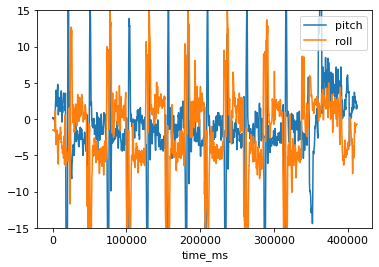

In [3]:
TeleDat.plot('time_ms', ['pitch', 'roll'], ylim=(-15,15))

### Plot gimbal pitch, as a function of time
Should be close to -90 degrees, if the gimbal is pointing straight down

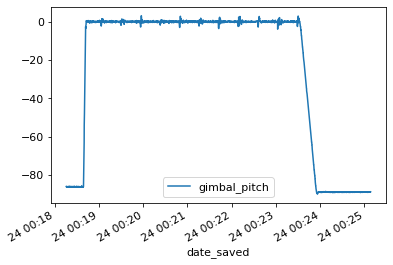

In [4]:
TeleDat.plot('date_saved', 'gimbal_pitch')

### Read in Flame spectral data

In [5]:
alldata = LoadData.load_from_dir(indir, calfile)

#### Create radiance column, based on DN, CalData and IntTime. Create Line column.

In [6]:
alldata['radiance'] = alldata.DN*alldata.CalData/alldata.IntTime
alldata['Line']=1

### Average all Flame spectra into 1nm bins

In [7]:
avgdata = WavelengthBin.wavelength_bin(alldata)

### Reset index and Merge
Combine the telemetry and spectral data together

In [8]:
alldat = avgdata.reset_index()
merge_data = pd.merge_asof(avgdata, TeleDat, on='date_saved')

### Plot height of drone as a function of time

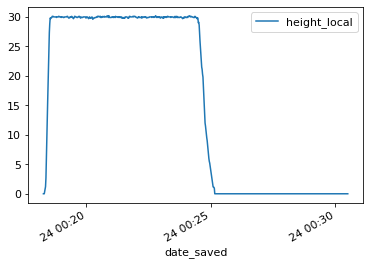

In [9]:
merge_data.plot('date_saved', 'height_local')

### Plot pitch of drone as a function of time

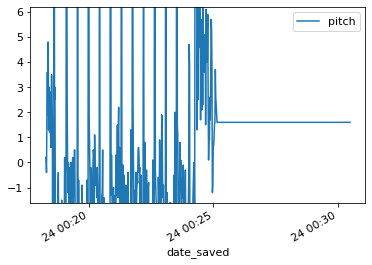

In [10]:
merge_data.plot('date_saved', 'pitch', ylim=(-1.6, 6.2))

### Define a quick scatter plot

In [11]:
def scatter_plot(xdata, ydata):
    plt.scatter(xdata, ydata, s=3)
    plt.xlim(xdata.min(), xdata.max())
    plt.ylim(ydata.min(), ydata.max())

### Plot drone compass heading as a function of time

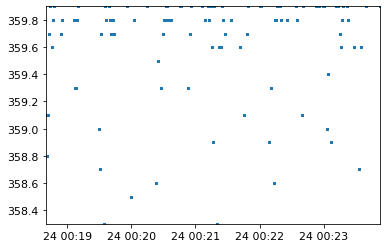

In [12]:
scatter_plot(merge_data[merge_data.compass_heading > 350]['date_saved'], merge_data[merge_data.compass_heading > 350]['compass_heading'])

### Plot radiance (at 450nm) as a function of time
This can be used to help identify times for panel measurements

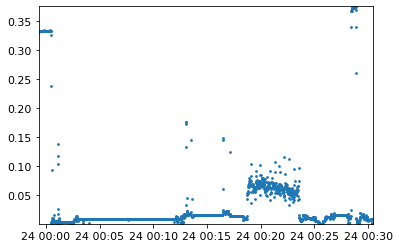

In [13]:
scatter_plot(merge_data[merge_data.Wavelength==450]['date_saved'], merge_data[merge_data.Wavelength==450]['radiance'])
#scatter_plot(merge_data[merge_data.Wavelength==450]['date_saved'], merge_data[merge_data.Wavelength==450]['height_local'])
plt.savefig('moo.png')

### Define panel spectra to be those where the 450nm radiance is greater than 0.3

In [14]:
tmp_panels = merge_data[np.logical_and(merge_data.Wavelength==450, merge_data.radiance > 0.3)]

### Define panel DataFrame

In [15]:
all_panels = merge_data.loc[merge_data['date_saved'].isin(tmp_panels.date_saved)]

### Plot panel radiance as a function of time

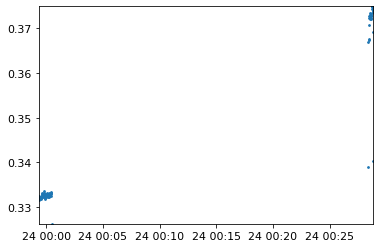

In [16]:
scatter_plot(all_panels[all_panels.Wavelength==450].date_saved, all_panels[all_panels.Wavelength==450].radiance)

### Create panel spectrum DataFrame format

In [17]:
all_panel_spec = MakeSpecDF.make_spec_df(all_panels)

### Plot all panel radiances

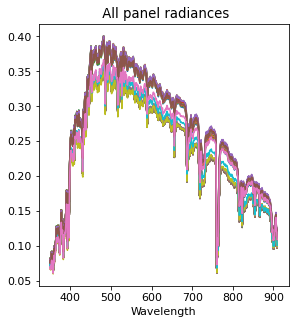

In [18]:
FIG_PanelRadiances.FIG_panel_radiances(all_panel_spec, outdir, field_data, fignum)

fignum += 1

### Cull non-line data from Flame DataFrame
Remove any data that does not form part of the field survey.
Removal is done with a combination of Latitude, local height of drone, drone pitch and compass heading.

Note: this will be different for different flights.

In [19]:
merge_data = merge_data[merge_data.Latitude < 0]
merge_data = merge_data[merge_data.height_local > 29.5]
merge_data = merge_data[merge_data.pitch > -1.6]
merge_data = merge_data[merge_data.pitch < 6.2]
merge_data = merge_data[np.logical_or(merge_data.compass_heading > 359, merge_data.compass_heading < 1)]

### Define grounds DataFrame

In [20]:
all_grounds = merge_data.copy()

### Plot a time series of ground radiance at 450nm

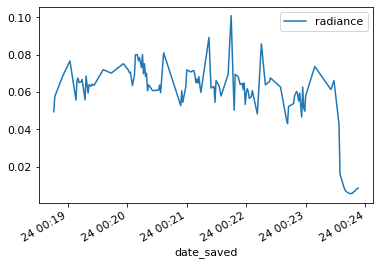

In [21]:
merge_data[merge_data.Wavelength==450].plot('date_saved', 'radiance')

### Create grounds spectral DataFrame

In [22]:
all_grounds_spec = MakeSpecDF.make_spec_df(all_grounds)

### Plot all ground spectra

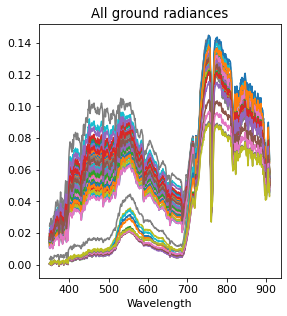

In [23]:
FIG_GroundSpectra.FIG_ground_spectra(all_grounds_spec, outdir, field_data, fignum)
fignum +=1

### Plot locations of all spectra that go into field site
Useful for checking if data are missing or if non-field site data were included.

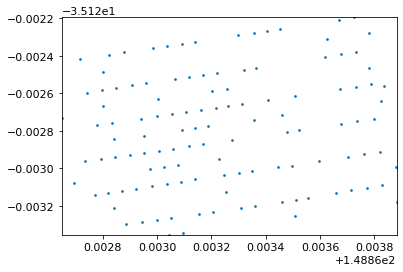

In [24]:
scatter_plot(merge_data[merge_data.Wavelength==350]['Longitude'], merge_data[merge_data.Wavelength==350]['Latitude'])

### Fill blank locations that contain NaNs
In case there are any field data with NaNs for location, just guess the location (Mullion)

In [25]:
all_panels.Longitude = all_panels.Longitude.fillna(148.862692)
all_panels.Latitude = all_panels.Latitude.fillna(-35.123277)

all_grounds.Longitude = all_grounds.Longitude.fillna(148.862692)
all_grounds.Latitude = all_grounds.Latitude.fillna(-35.123277)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Add Solar Angle to both panels and grounds DataFrames

In [26]:
all_panels, all_grounds = SolarAngle.solar_angle(all_panels, all_grounds, field_data)

../SRC/SolarAngle.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_spectra['Solar_angle'] = 1.0


### Assume that there are no panels or grounds to further delete and copy all -> good

In [27]:
good_panels = all_panels.copy()
good_grounds = all_grounds.copy()

### Apply panel BRF function to panel data

In [28]:
all_panels = PanelBRF.Panel_BRF(all_panels, field_data)

### Create Time Relative DataFrames

In [29]:
gpta, adta = CreateTimeRelativeDF.create_time_relative_dfs(all_panels, all_grounds)

### Plot spectra points, as a function of time
Orange ticks are panel data<BR>
Blue crosses are ground data

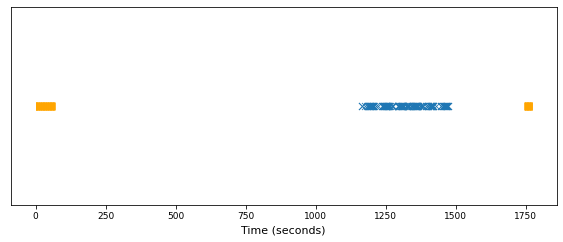

In [30]:
FIG_AllTimelines.FIG_all_timelines(gpta, adta, outdir, field_data, fignum)
fignum += 1

### Plot wavelength-averaged panel radiances as a time sequence

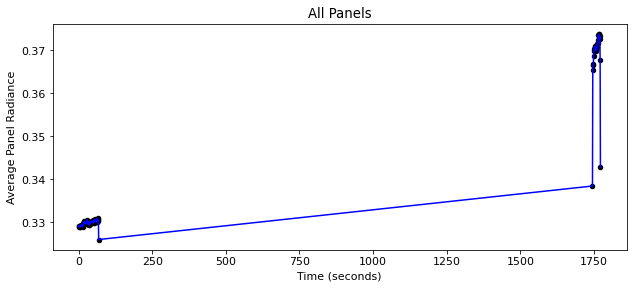

In [31]:
all_panel_mean = all_panel_spec.mean(axis=1)

gpta = FIG_NormalisedPanelsTimeline.normalise_spectra(all_panel_mean, all_panel_spec, gpta, field_data)

FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(gpta, outdir, field_data, fignum)

fignum += 1

### Fudge locations for the purposes of determining Solar Angle and then fitting insolation

In [32]:
gpta['Latitude'] = -35.123277
gpta['Longitude'] = 148.862692
adta['Latitude'] = -35.123277
adta['Longitude'] = 148.862692

### Fit insolation

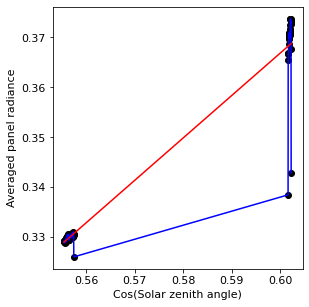

In [33]:
slope, intercept, coszenith = FIG_InsolationFit.FIG_insolation_fit(gpta, outdir, field_data, fignum)
fignum += 1

### Scale good panels to insolation curve

Use the fitted insolation curve to determine individual offsets for each panel measurement and then divide<BR>
off the differences. This effectively removes any individual variations in the absolute scaling of panel<BR>
measurements.

In [34]:
#good_panels = ScalePanels.scale_panels(slope, intercept, coszenith, gpta, good_panels, field_data)

### Scale ground spectra to insolation curve

For each line, calculate the mean panel spectrum and determine the fit at the according mean Solar zenith angle.<BR>
Then determine individual fits for all ground data within the line and apply the ratio of the panel mean fit to<BR>
ground fit to the good_grounds dataframe.

In [35]:
#good_grounds = ScaleGrounds.scale_grounds(good_panels, good_grounds, slope, intercept, field_data)

### Define the K-factor

This reads a standard file with a response curve for the detector, given an ideally white surface.<BR>
Then "k_f" is defined for the K-factor.

In [36]:
k_f = KFactor.k_factor(panel_dir, in_panel)

### Limit K-factor to shorter than 910nm (limit of Flame spectrum)

In [37]:
k_f = k_f[k_f.index <910]

### Re-Make Spectral Dataframes

After re-scaling of both good_panels and good_grounds, recreate the good_panel_spec and<BR>
good_grounds_spec dataframes

In [38]:
good_panel_spec = MakeSpecDF.make_spec_df(good_panels)
good_grounds_spec = MakeSpecDF.make_spec_df(good_grounds)

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [39]:
SpecRename.spec_rename(good_panel_spec, good_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec, field_data)

### Add "radiance1-" to column headers

In [40]:
good_panel_spec = good_panel_spec.rename(columns={x:y for x,y in zip(good_panel_spec.columns,range(len(good_panel_spec.columns)))}).add_prefix('radiance1-')
good_grounds_spec = good_grounds_spec.rename(columns={x:y for x,y in zip(good_grounds_spec.columns,range(len(good_grounds_spec.columns)))}).add_prefix('radiance1-')


### Create dataframe with Reflectances

In [41]:
all_refls = CreateReflectances.create_reflectances(good_panels, good_panel_spec, good_grounds_spec, k_f, field_data)

../SRC/CreateReflectances.py:50: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  line_refls = pd.np.multiply(refl_tmp, k_f)


### Plot all ground reflectances

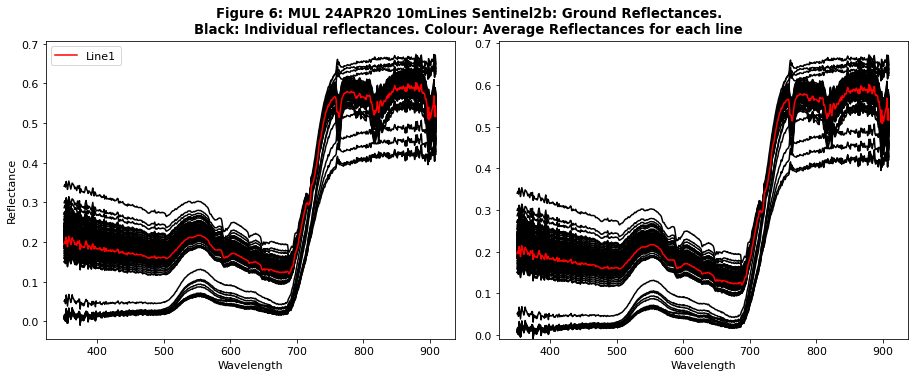

In [42]:
FIG_Reflectances.FIG_reflectances(good_panels, all_refls, colpac, outdir, field_data, fignum)
fignum += 1

### Make time-averaged Flame spectrum

In [43]:
flameavg = all_refls.mean(axis=1)

### Read in ASD time-averaged spectrum

In [44]:
asdavg = pd.read_pickle('24APR20.pick')

FileNotFoundError: [Errno 2] No such file or directory: '24APR20.pick'

### Plot a direct comparison of FLame and ASD time-averaged spectra

In [ ]:
plt.plot(flameavg)
plt.plot(asdavg)
plt.ylim(0,0.6)
plt.xlim(340,915)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend(['Drone average spectrum', 'ASD average spectrum'])
plt.savefig('comp.png')

### Plot ratio of flame/ASD spectra

In [ ]:
(flameavg/asdavg).plot(xlim=(350,910), ylim=(0.5,1))

In [ ]:
scatter_plot(gpta['date_saved'], gpta['Averaged_Panels'])
#plt.xlim(datetime(2020,5,4,0,15,30), datetime(2020,5,4,0,15,55))

In [ ]:
scatter_plot(all_panels[all_panels.Wavelength==450].date_saved, all_panels[all_panels.Wavelength==450].radiance)
#plt.xlim(datetime(2020,5,4,0,1), datetime(2020,5,4,0,20))
#plt.ylim(52,57)

### Apply weighted band responses to all reflectances

In [ ]:
for i in range(910, 2501):
    all_refls.loc[i] = all_refls.loc[909]

In [ ]:
ls_result_df, s2_result_df, ls_band, s2_band = ApplyWeights.apply_weights(f_name, all_refls, sat_resp, field_data)

### Reformat band reflectances and apply to dataframe "ground_bands"

In [ ]:
ls_ground_bands = ReformatDF.reformat_df(good_grounds, ls_result_df)
s2_ground_bands = ReformatDF.reformat_df(good_grounds, s2_result_df)

# Figure 

### Plot band reflectances

In [ ]:
FIG_BandReflectances.FIG_band_reflectances(ls_ground_bands, ls_result_df, ls_band, s2_ground_bands, s2_result_df, s2_band, colpac, outdir, field_data, fignum)

fignum += 1

In [ ]:
FIG_ReflectancesBand.FIG_reflectances_band(ls_ground_bands, ls_result_df, ls_band, s2_ground_bands, s2_result_df, s2_band, good_panels, all_refls, colpac, outdir, field_data, fignum)

fignum += 1

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

In [ ]:
FIG_SpecHistogram.FIG_spec_histogram(ls_ground_bands, s2_ground_bands, outdir, field_data, fignum)
fignum += 1

### Outlying ground spectra

Display the spectra with maximum and minimum values. These can be compared to the histograms above<BR>
    to identify any outlying spectra that need to be identified as bad ground spectra.

In [ ]:
OutlyingSpec.outlying_spec(ls_ground_bands, s2_ground_bands, field_data)

### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [ ]:
from SRC.SolarAngle import solang
ls_ground_bands['Solar_angle'] = ls_ground_bands.apply(solang, axis=1)
s2_ground_bands['Solar_angle'] = s2_ground_bands.apply(solang, axis=1)

### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [ ]:
ls_ground_brdf, s2_ground_brdf, hb, br = BRDF.ReadAndCalc(brdf_data, ls_ground_bands, s2_ground_bands, field_data)

### Choose bands for Landsat 8 and Sentinel satellite data

In [ ]:
from SRC.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

In [ ]:
FIG_BandExtents.FIG_band_extents(all_refls, band_min, band_max, outdir, field_data, fignum)
fignum += 1

### Read in ASD data from pickle files

In [ ]:
ls_ground_brdf_ASD = pd.read_pickle('04MAY20_ls_ground_brdf.pick')
s2_ground_brdf_ASD = pd.read_pickle('04MAY20_s2_ground_brdf.pick')

### Plot relative locations of Flame and ASD data

In [ ]:
scatter_plot(s2_ground_brdf.Longitude, s2_ground_brdf.Latitude)
scatter_plot(s2_ground_brdf_ASD.Longitude, s2_ground_brdf_ASD.Latitude)
plt.xlim(148.8625, 148.8640)
plt.ylim(-35.1235, -35.1222)

### Fudge date for satellite overpass
This is needed so that data can be plotted, whilst there is no satellite data in Datacube yet.
Once satellite data become available, this step should be dropped and subsequent uses of "fudate" should go back to "ground_brdf".

In [ ]:
ls_fudate = ls_ground_brdf_ASD.copy()
s2_fudate = s2_ground_brdf_ASD.copy()
ls_fudate.date_saved = datetime(2019,5,4)
s2_fudate.date_saved = datetime(2019,5,4)

### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.<BR>
ls8_usgs_array will contain the USGS Level 2 product of Landsat 8 data.<BR>
ls8_usgs_bigarray will be the larger version of ls8_usgs_array.<P>
    
BRDF data is sourced/applied from satellite yaml file to match field and satellite processing for Landsat 8.<BR>
ground_WSbrdf is the brdf calculated for the whole of scene (based on satellite yaml file).

In [ ]:
ls_sat_array, ls_sat_bigarray, s2_sat_array, s2_sat_bigarray, ls8_usgs_array, ls8_usgs_bigarray, solar_zenith,\
ls_query, s2_query, ls_dc, s2_dc, ls_ground_WSbrdf = QueryAndCreate.query_and_create(ls_fudate, s2_fudate, ls_ground_bands, s2_ground_bands, field_data, Corners, RockWalk, StartCorner)

# Figure 

### Plot relative locations of field and satellite data

In [ ]:
ls_xloc, s2_xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ls_ground_brdf, s2_ground_brdf, ls_sat_array, s2_sat_array, colpac, outdir, field_data, fignum)
fignum +=1

In [ ]:
ls_ASD_xloc, s2_ASD_xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ls_ground_brdf_ASD, s2_ground_brdf_ASD, ls_sat_array, s2_sat_array, colpac, outdir, field_data, fignum)
fignum +=1

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [ ]:
ls_field_array, s2_field_array = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)
ls_field_WSarray, dummy = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)

In [ ]:
ls_field_ASD_array, s2_field_ASD_array = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_brdf_ASD, s2_ground_brdf_ASD, ls_ASD_xloc, s2_ASD_xloc, field_data)

# Figure 

### Plot large-area context RGB array for Satellite data

In [ ]:
if field_data[3] == 'Landsat8':
    FIG_SatBigRGB.FIG_sat_bigRGB(ls_sat_array, ls_sat_bigarray, outdir, field_data, fignum)
else:
    FIG_SatBigRGB.FIG_sat_bigRGB(s2_sat_array, s2_sat_bigarray, outdir, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Satellite data

In [ ]:
if field_data[3] == 'Landsat8':
    FIG_SatRGB.FIG_sat_RGB(ls_sat_array, outdir, field_data, fignum)
else:
    FIG_SatRGB.FIG_sat_RGB(s2_sat_array, outdir, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Field data

In [ ]:
if field_data[3] == 'Landsat8':
    FIG_FieldRGB.FIG_field_RGB(ls_field_WSarray, outdir, field_data, fignum)
else:
    FIG_FieldRGB.FIG_field_RGB(s2_field_array, outdir, field_data, fignum)
fignum += 1

In [ ]:
if field_data[3] == 'Landsat8':
    FIG_FieldRGB.FIG_field_RGB(ls_field_WSarray, outdir, field_data, fignum)
else:
    FIG_FieldRGB.FIG_field_RGB(s2_field_ASD_array, outdir, field_data, fignum)
fignum += 1

## Figure
### Variance of satellite data

Band-by-band plots of the ratio of satellite data, divided by the mean, for each band are shown.
The title also lists the min, max and mean variance. Variance is defined as the ratio of the standard
deviation divided by the mean, for each band. The mean variance should typically be less than 5%.

In [ ]:
if field_data[3] == 'Landsat8':
    variance = FIG_SatBands.FIG_sat_bands(ls_sat_array, ls_field_WSarray, outdir, field_data, fignum)
else:
    variance = FIG_SatBands.FIG_sat_bands(s2_sat_array, s2_field_ASD_array, outdir, field_data, fignum)
fignum += 1

# Figure

### Plot ratio arrays for each band

Each panel shows the ratio of satellite/field data.

In [ ]:
if field_data[3] == 'Landsat8':
    FIG_RatioArrays.FIG_ratio_arrays(ls_sat_array, ls_field_WSarray, outdir, field_data, fignum)
else:
    FIG_RatioArrays.FIG_ratio_arrays(s2_field_ASD_array, s2_field_array, outdir, field_data, fignum)
fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [ ]:
ls_fstat_df, s2_fstat_df = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
ls_fstat_WSdf, dummy = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, field_data)

if field_data[6] == 'USGS':
    ls_fstat_usgs_df, dummy = CreateStats.create_stats(ls8_usgs_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
else:
    ls_fstat_usgs_df = 0

In [ ]:
ls_fstat_ASD_df, s2_fstat_ASD_df = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_brdf_ASD, s2_ground_brdf_ASD, field_data)

## Create a statistics dataframe, comparing satellite and field data,
for only those satellite pixels which overlap with at least one field data position.

In [ ]:
ls_finner_df, s2_finner_df = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_array, s2_field_array, ls_ground_brdf, s2_ground_brdf, ls_fstat_df, s2_fstat_df, field_data)
ls_finner_WSdf, dummy = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_WSarray, s2_field_array, ls_ground_WSbrdf, s2_ground_brdf, ls_fstat_WSdf, s2_fstat_df, field_data)
ls_finner_ASD_df, s2_finner_ASD_df = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_ASD_array, s2_field_ASD_array, ls_ground_brdf_ASD, s2_ground_brdf_ASD, ls_fstat_ASD_df, s2_fstat_ASD_df, field_data)


# Figure

### Plot comparison spectra of satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the satellite and field data, based on the standard deviation of the pixels
within the field. The black line shows the satellite data, which has been averaged over all pixels that satisfy the Datacube query ie. all pixels shown in Figure 11. The orange line shows satellite data which has been averaged over only those pixels that overlap with at least one field measurement.

In [ ]:
if field_data[3] == 'Landsat8':
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(ls_sat_array, ls_fstat_WSdf, ls_finner_WSdf, outdir, field_data, fignum)
else:
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(s2_field_ASD_array, s2_fstat_ASD_df, s2_finner_ASD_df, outdir, field_data, fignum)
fignum += 1

In [ ]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldBands.FIG_sat_field_bands(ls_sat_array, ls_fstat_WSdf, ls_finner_WSdf, output, field_data, fignum)
else:
    FIG_SatFieldBands.FIG_sat_field_bands(s2_sat_array, s2_fstat_ASD_df, s2_finner_ASD_df, outdir, field_data, fignum)
fignum += 1

# Figure

### Comparison plot of Field and satellite data

Plot shows a pixel-by-pixel comparison of all pixels where field data exists.<BR> 
Different band data are shown in different colours and different symbols.

In [ ]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(ls_sat_array, ls_field_WSarray, plot_scale, output, field_data, fignum)
else:
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(s2_sat_array, s2_field_array, plot_scale, outdir, field_data, fignum)
fignum += 1

In [ ]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(ls_sat_array, ls_field_WSarray, plot_scale, ls_fstat_WSdf, output, field_data, fignum)
else:
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(s2_sat_array, s2_field_array, plot_scale, s2_fstat_df, outdir, field_data, fignum)
fignum += 1

## Print out summary data sheet

In [ ]:
if field_data[3] == 'Landsat8':
    PrintSheet.print_sheet(ls_ground_WSbrdf, ls_sat_array, ls_fstat_WSdf, indir, output, field_data, Corners, RockWalk, StartCorner, variance, ls_query, ls_dc)
else:
    PrintSheet.print_sheet(s2_ground_brdf, s2_sat_array, s2_fstat_df, indir, outdir, field_data, Corners, RockWalk, StartCorner, variance, s2_query, s2_dc)

In [ ]:
OutputCSVs.output_csvs(ls_fstat_ASD_df, s2_fstat_df, ls_sat_array, s2_sat_array, ls_ground_brdf_ASD, s2_ground_brdf_ASD, field_data)

## How long did this notebook take to run?

In [ ]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")